<a href="https://colab.research.google.com/github/raihanewubd/selfSupervised/blob/main/AAV_SelSupervised_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as T
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import numpy as np
from PIL import Image
from google.colab import drive
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import os
import zipfile
import glob
import shutil
from collections import Counter
from scipy import stats
from collections import Counter

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define dataset path
zip_path = "/content/drive/MyDrive/AAVDATASET/100mV1s_segment_raw.zip"
extract_path = "/content/dataset1/"
# Unzip dataset
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [ ]:
data_dir = '/content/dataset/train_val_photos'

In [ ]:
# Define contrastive (SimCLR-style) transformations.
contrastive_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
class ContrastiveLearningViewGenerator:
    """
    Given a base transformation, generate two augmented views of the same image.
    """
    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        return [self.base_transform(x), self.base_transform(x)]


In [ ]:
# Valid image extensions.
valid_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
def is_valid_file(file_path):
    if any(part.startswith('.') for part in file_path.split(os.sep)):
        return False
    return file_path.lower().endswith(valid_extensions)

# Directory of your dataset (assumes folder structure as before)
data_dir = '/content/dataset/train_val_photos'
transform = ContrastiveLearningViewGenerator(contrastive_transforms)
dataset = datasets.ImageFolder(root=data_dir, transform=transform, is_valid_file=is_valid_file)
print("Dataset class mapping:", dataset.class_to_idx)

batch_size = 128
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)

Dataset class mapping: {'Double': 0, 'Empty': 1, 'Single': 2}


In [ ]:
class SimCLRResNet50(nn.Module):
    def __init__(self, projection_dim=128):
        super(SimCLRResNet50, self).__init__()
        # Load a pretrained ResNet50 model
        self.backbone = models.resnet50(pretrained=True)
        # Remove the final fully connected layer; output will be a 2048-dim feature vector.
        self.backbone.fc = nn.Identity()
        # Define a projection head: a two-layer MLP.
        self.projection_head = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, projection_dim)
        )

    def forward(self, x):
        features = self.backbone(x)           # Shape: (batch, 2048)
        projections = self.projection_head(features)
        return F.normalize(projections, dim=1)  # L2 normalization

In [ ]:
model = SimCLRResNet50(projection_dim=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]


In [ ]:
class NTXentLoss(nn.Module):
    """
    Normalized Temperature-Scaled Cross Entropy Loss.
    """
    def __init__(self, batch_size, temperature=0.5, device='cpu'):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.mask = self._get_correlated_mask().to(device)

    def _get_correlated_mask(self):
        N = 2 * self.batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(self.batch_size):
            mask[i, self.batch_size + i] = 0
            mask[self.batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        N = 2 * self.batch_size
        # Concatenate projections from both views.
        z = torch.cat([z_i, z_j], dim=0)  # Shape: (2B, projection_dim)
        # Cosine similarity matrix.
        sim = torch.matmul(z, z.T) / self.temperature
        # Positive similarities on the diagonal offset by batch_size.
        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        positives = torch.cat([sim_i_j, sim_j_i], dim=0).reshape(N, 1)
        negatives = sim[self.mask].reshape(N, -1)
        labels = torch.zeros(N, dtype=torch.long).to(self.device)
        logits = torch.cat([positives, negatives], dim=1)
        loss = self.criterion(logits, labels)
        loss = loss / N
        return loss

nt_xent_loss = NTXentLoss(batch_size=batch_size, temperature=0.5, device=device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
num_epochs = 50  # Adjust number of epochs as needed

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for (imgs, _) in train_loader:
        # Each sample returns two augmented views.
        # imgs shape: [batch_size, 2, C, H, W]
        imgs = torch.stack(imgs, dim=1).to(device)  # (B, 2, C, H, W)
        img1 = imgs[:, 0, :, :, :]
        img2 = imgs[:, 1, :, :, :]

        optimizer.zero_grad()
        z_i = model(img1)  # Projections for view 1
        z_j = model(img2)  # Projections for view 2

        loss = nt_xent_loss(z_i, z_j)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

print("Contrastive training with ResNet50 completed!")

Epoch [1/50] Loss: 4.8943
Epoch [2/50] Loss: 4.4959
Epoch [3/50] Loss: 4.3831
Epoch [4/50] Loss: 4.3317


In [ ]:
# Define valid image extensions and a function to filter out hidden files
valid_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
def is_valid_file(file_path):
    if any(part.startswith('.') for part in file_path.split(os.sep)):
        return False
    return file_path.lower().endswith(valid_extensions)

# Define transformations: ResNet50 expects 224x224 images with ImageNet normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_dir, transform=transform, is_valid_file=is_valid_file)
print("Full dataset class mapping:", dataset.class_to_idx)
# For example, you might see: {'Double': 0, 'Single': 1, 'Unkown': 2}

# Filter out the known classes ("Double" and "Single")
known_class_names = ['Double', 'Single']
known_classes = [dataset.class_to_idx[name] for name in known_class_names]
known_indices = [i for i, (_, label) in enumerate(dataset.samples) if label in known_classes]
known_dataset = Subset(dataset, known_indices)

# Split the known dataset into training (80%) and validation (20%) sets
train_size = int(0.8 * len(known_dataset))
val_size = len(known_dataset) - train_size
train_dataset, val_dataset = random_split(known_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

Full dataset class mapping: {'Double': 0, 'Single': 1}


In [ ]:
# Check unique labels in the known_dataset
all_labels = [label for _, label in known_dataset]
print("Unique labels in known_dataset:", set(all_labels))

Unique labels in known_dataset: {0, 1}


In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [ ]:
# Instantiate and modify ResNet50
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Two classes: "Double" and "Single"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
##############################################
# 4. Training Loop with Validation
##############################################

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for images, labels in train_loader:
        try:
            images = images.to(device)  # Move images to GPU
            labels = labels.to(device)  # Move labels to GPU

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        except RuntimeError as e:
            print(f"Error occurred during training: {e}")
            print(f"Image shape: {images.shape}")
            print(f"Labels: {labels}")
            # You might want to save the problematic image for further inspection
            # torchvision.utils.save_image(images[0], 'problematic_image.png')
            break  # Exit the loop to prevent further errors
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# Save the fine-tuned model
torch.save(model.state_dict(), "resnet50_finetuned.pth")
print("Model saved as 'resnet50_finetuned.pth'")

Epoch [1/10] Train Loss: 0.2220, Train Acc: 0.9137 | Val Loss: 2.9097, Val Acc: 0.5236
Epoch [2/10] Train Loss: 0.1195, Train Acc: 0.9669 | Val Loss: 3.2235, Val Acc: 0.5259
Epoch [3/10] Train Loss: 0.1080, Train Acc: 0.9616 | Val Loss: 2.8051, Val Acc: 0.6203
Epoch [4/10] Train Loss: 0.1046, Train Acc: 0.9669 | Val Loss: 1.1347, Val Acc: 0.7146
Epoch [5/10] Train Loss: 0.0761, Train Acc: 0.9752 | Val Loss: 0.1346, Val Acc: 0.9434
Epoch [6/10] Train Loss: 0.0733, Train Acc: 0.9728 | Val Loss: 2.4247, Val Acc: 0.5354
Epoch [7/10] Train Loss: 0.0681, Train Acc: 0.9770 | Val Loss: 0.0756, Val Acc: 0.9811
Epoch [8/10] Train Loss: 0.0419, Train Acc: 0.9870 | Val Loss: 3.1346, Val Acc: 0.5236
Epoch [9/10] Train Loss: 0.0626, Train Acc: 0.9840 | Val Loss: 0.7144, Val Acc: 0.7476
Epoch [10/10] Train Loss: 0.0241, Train Acc: 0.9929 | Val Loss: 0.2116, Val Acc: 0.9340
Model saved as 'resnet50_finetuned.pth'


# 1. Data Augmentation and Dataset Setup

In [ ]:
# Define a set of augmentations for contrastive learning (SimCLR-style)
contrastive_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# A wrapper that produces two augmented views for each image
class ContrastiveLearningViewGenerator:
    def __init__(self, base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        return [self.base_transform(x), self.base_transform(x)]

# Optionally, filter valid files (if needed)
def is_valid_file(file_path):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
    if any(part.startswith('.') for part in file_path.split(os.sep)):
        return False
    return file_path.lower().endswith(valid_extensions)

In [ ]:
data_dir = '/content/dataset1/train_val_photos'
view_generator = ContrastiveLearningViewGenerator(contrastive_transforms)
dataset = datasets.ImageFolder(root=data_dir, transform=view_generator, is_valid_file=is_valid_file)
print("Dataset class mapping:", dataset.class_to_idx)

Dataset class mapping: {'Double': 0, 'Single': 1, 'Unknown': 2}


In [ ]:
# Use all data for contrastive learning; you can include unknown samples if desired.
batch_size = 128
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)


# 2. Build the Model Using Fine-Tuned ResNet50

In [ ]:
model_ft = models.resnet50(pretrained=False)
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, 2)  # Originally fine-tuned for 2 classes
model_ft.load_state_dict(torch.load("resnet50_finetuned.pth"))
model_ft.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Remove the classification head (set it to Identity) to use the backbone for feature extraction
model_ft.fc = nn.Identity()


In [ ]:
# Define a projection head (an MLP) for SimCLR
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=2048, projection_dim=128):
        super(ProjectionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, projection_dim)
        )
    def forward(self, x):
        x = self.net(x)
        return F.normalize(x, dim=1)

In [ ]:
# Combine the backbone and projection head into one model
class SimCLRModel(nn.Module):
    def __init__(self, backbone, projection_dim=128):
        super(SimCLRModel, self).__init__()
        self.backbone = backbone  # Pre-trained fine-tuned ResNet50 backbone
        self.projection_head = ProjectionHead(input_dim=2048, projection_dim=projection_dim)
    def forward(self, x):
        features = self.backbone(x)
        projections = self.projection_head(features)
        return projections

In [ ]:
# Instantiate the SimCLR model using the fine-tuned backbone
model = SimCLRModel(backbone=model_ft, projection_dim=128)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 3. Define the NT-Xent Loss (Contrastive Loss)

In [ ]:
class NTXentLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5, device='cpu'):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.device = device
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.mask = self._get_correlated_mask().to(device)

    def _get_correlated_mask(self):
        N = 2 * self.batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(self.batch_size):
            mask[i, self.batch_size + i] = 0
            mask[self.batch_size + i, i] = 0
        return mask

    def forward(self, z_i, z_j):
        N = 2 * self.batch_size
        z = torch.cat([z_i, z_j], dim=0)  # shape: (2B, projection_dim)
        sim = torch.matmul(z, z.T) / self.temperature  # cosine similarity matrix
        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        positives = torch.cat([sim_i_j, sim_j_i], dim=0).reshape(N, 1)
        negatives = sim[self.mask].reshape(N, -1)
        labels = torch.zeros(N, dtype=torch.long).to(self.device)
        logits = torch.cat([positives, negatives], dim=1)
        loss = self.criterion(logits, labels)
        loss = loss / N
        return loss
nt_xent_loss = NTXentLoss(batch_size=batch_size, temperature=0.5, device=device)

# Training Loop for Contrastive Learning

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=3e-4)
num_epochs = 50  # Adjust as needed

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for (imgs, _) in train_loader:
        # Each sample returns two augmented views: shape [B, 2, C, H, W]
        imgs = torch.stack(imgs, dim=1).to(device)  # (B, 2, C, H, W)
        img1 = imgs[:, 0, :, :, :]
        img2 = imgs[:, 1, :, :, :]

        optimizer.zero_grad()
        z_i = model(img1)  # Projections for view 1
        z_j = model(img2)  # Projections for view 2

        loss = nt_xent_loss(z_i, z_j)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

print("SimCLR training complete!")

Epoch [1/50] Loss: 5.5495
Epoch [2/50] Loss: 5.5410
Epoch [3/50] Loss: 5.5275
Epoch [4/50] Loss: 5.4337
Epoch [5/50] Loss: 5.3289
Epoch [6/50] Loss: 5.1756
Epoch [7/50] Loss: 5.0084
Epoch [8/50] Loss: 4.8862
Epoch [9/50] Loss: 4.7346
Epoch [10/50] Loss: 4.6655
Epoch [11/50] Loss: 4.5850
Epoch [12/50] Loss: 4.5505
Epoch [13/50] Loss: 4.5033
Epoch [14/50] Loss: 4.4735
Epoch [15/50] Loss: 4.4676
Epoch [16/50] Loss: 4.4391
Epoch [17/50] Loss: 4.4404
Epoch [18/50] Loss: 4.4165
Epoch [19/50] Loss: 4.3809
Epoch [20/50] Loss: 4.3496
Epoch [21/50] Loss: 4.3660
Epoch [22/50] Loss: 4.3401
Epoch [23/50] Loss: 4.3241
Epoch [24/50] Loss: 4.3197
Epoch [25/50] Loss: 4.3070
Epoch [26/50] Loss: 4.2834
Epoch [27/50] Loss: 4.2832
Epoch [28/50] Loss: 4.2765
Epoch [29/50] Loss: 4.2823
Epoch [30/50] Loss: 4.2478
Epoch [31/50] Loss: 4.2597
Epoch [32/50] Loss: 4.2523
Epoch [33/50] Loss: 4.2405
Epoch [34/50] Loss: 4.2515
Epoch [35/50] Loss: 4.2442
Epoch [36/50] Loss: 4.2343
Epoch [37/50] Loss: 4.2405
Epoch [38/

# Downstream Task

In [ ]:
# Define transforms for ResNet50 (224x224 with ImageNet normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Directory of your dataset
data_dir = '/content/dataset1/train_val_photos'

# Load full dataset (ImageFolder expects a folder per class)
dataset = datasets.ImageFolder(root=data_dir, transform=transform)
print("Full dataset class mapping:", dataset.class_to_idx)
# e.g., {'Double': 0, 'Single': 1, 'Unkown': 2}

# For training, we use only the known classes: "Double" and "Single"
known_class_names = ['Double', 'Single']
known_classes = [dataset.class_to_idx[name] for name in known_class_names]
known_indices = [i for i, (_, label) in enumerate(dataset.samples) if label in known_classes]
known_dataset = Subset(dataset, known_indices)

# Split known_dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(known_dataset))
val_size = len(known_dataset) - train_size
train_dataset, val_dataset = random_split(known_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

# For evaluation, use the full dataset (which includes the "Unkown" class)
eval_loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

Full dataset class mapping: {'Double': 0, 'Single': 1, 'Unknown': 2}


In [ ]:
# Instantiate a ResNet50 model without pretrained weights
backbone = models.resnet50(pretrained=False)
num_features = backbone.fc.in_features

# Replace the final fully connected layer with an Identity layer so the backbone outputs a 2048-dim feature vector.
backbone.fc = nn.Identity()

# Load the fine-tuned state dictionary with strict=False to ignore fc weights in the state dict
state_dict = torch.load("resnet50_finetuned.pth")
backbone.load_state_dict(state_dict, strict=False)
backbone.eval()  # Set to evaluation mode

# Move backbone to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
backbone = backbone.to(device)

# Optionally freeze the backbone (for linear evaluation)
for param in backbone.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# Define the downstream model: backbone + linear classifier
class DownstreamModel(nn.Module):
    def __init__(self, backbone, num_classes=2):
        super(DownstreamModel, self).__init__()
        self.backbone = backbone  # Feature extractor (2048-dim output)
        self.classifier = nn.Linear(2048, num_classes)  # New linear classifier for known classes
    def forward(self, x):
        features = self.backbone(x)  # (B, 2048)
        out = self.classifier(features)  # (B, num_classes)
        return out

In [ ]:
# Instantiate downstream model (2 classes: "Double" and "Single")
model = DownstreamModel(backbone, num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  # Only train classifier head


In [ ]:
# -------------------------------
# 3. Training Loop (Downstream Task)
# -------------------------------

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)
    print(f"Epoch {epoch+1}/{num_epochs} - Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")


Epoch 1/10 - Train Loss: 0.0533, Acc: 0.9846
Epoch 1/10 - Val Loss: 0.0146, Acc: 0.9976
Epoch 2/10 - Train Loss: 0.0402, Acc: 0.9894
Epoch 2/10 - Val Loss: 0.0137, Acc: 0.9976
Epoch 3/10 - Train Loss: 0.0351, Acc: 0.9900
Epoch 3/10 - Val Loss: 0.0221, Acc: 0.9953
Epoch 4/10 - Train Loss: 0.0239, Acc: 0.9917
Epoch 4/10 - Val Loss: 0.0127, Acc: 0.9953
Epoch 5/10 - Train Loss: 0.0352, Acc: 0.9882
Epoch 5/10 - Val Loss: 0.0198, Acc: 0.9953
Epoch 6/10 - Train Loss: 0.0413, Acc: 0.9882
Epoch 6/10 - Val Loss: 0.0134, Acc: 0.9929
Epoch 7/10 - Train Loss: 0.0339, Acc: 0.9900
Epoch 7/10 - Val Loss: 0.0187, Acc: 0.9953
Epoch 8/10 - Train Loss: 0.0378, Acc: 0.9876
Epoch 8/10 - Val Loss: 0.0143, Acc: 0.9929
Epoch 9/10 - Train Loss: 0.0273, Acc: 0.9935
Epoch 9/10 - Val Loss: 0.0135, Acc: 0.9953
Epoch 10/10 - Train Loss: 0.0396, Acc: 0.9882
Epoch 10/10 - Val Loss: 0.0154, Acc: 0.9929


In [ ]:
# -------------------------------
# 4. Evaluation on Full Dataset
# -------------------------------
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in eval_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Classification Report on Evaluation Dataset:")
target_names = list(dataset.class_to_idx.keys())
print(classification_report(all_labels, all_preds, target_names=target_names))

Classification Report on Evaluation Dataset:
              precision    recall  f1-score   support

      Double       0.86      1.00      0.92      1028
      Single       0.70      0.99      0.82      1088
     Unknown       0.00      0.00      0.00       616

    accuracy                           0.77      2732
   macro avg       0.52      0.66      0.58      2732
weighted avg       0.60      0.77      0.67      2732



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# -------------------------------
# 4. Evaluation with Open-Set Recognition
# -------------------------------
# Here we incorporate a simple open-set technique by thresholding the max softmax probability.
# If the maximum probability is below a chosen threshold, we label the sample as "Unknown" (label 2).

unknown_threshold = 0.95  # Adjust this threshold based on validation performance

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in eval_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        max_probs, preds = torch.max(probs, dim=1)
        preds = preds.cpu().numpy()
        max_probs = max_probs.cpu().numpy()
        for i in range(len(preds)):
            # If the max probability is below the threshold, assign "Unknown" label (2)
            if max_probs[i] < unknown_threshold:
                all_preds.append(2)
            else:
                all_preds.append(preds[i])
        all_labels.extend(labels.cpu().numpy())

# Print classification report using sklearn's classification_report
from sklearn.metrics import classification_report
# Assuming dataset.class_to_idx maps {'Double': 0, 'Single': 1, 'Unkown': 2}
target_names = list(dataset.class_to_idx.keys())
print("Classification Report with Open-Set Recognition:")
print(classification_report(all_labels, all_preds, target_names=target_names))


Classification Report with Open-Set Recognition:
              precision    recall  f1-score   support

      Double       0.96      0.99      0.98      1028
      Single       0.78      0.96      0.86      1088
     Unknown       0.85      0.46      0.60       616

    accuracy                           0.86      2732
   macro avg       0.86      0.80      0.81      2732
weighted avg       0.86      0.86      0.85      2732



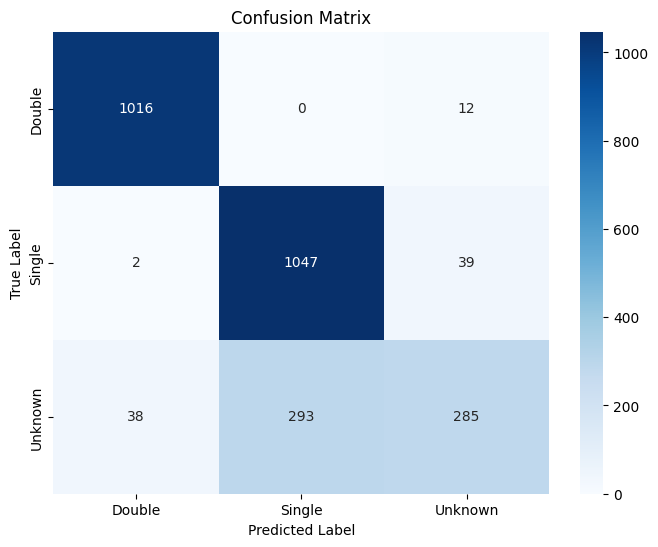

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ---- Confusion Matrix ----
# Compute confusion matrix using scikit-learn
cm = confusion_matrix(all_labels, all_preds)
target_names = list(dataset.class_to_idx.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

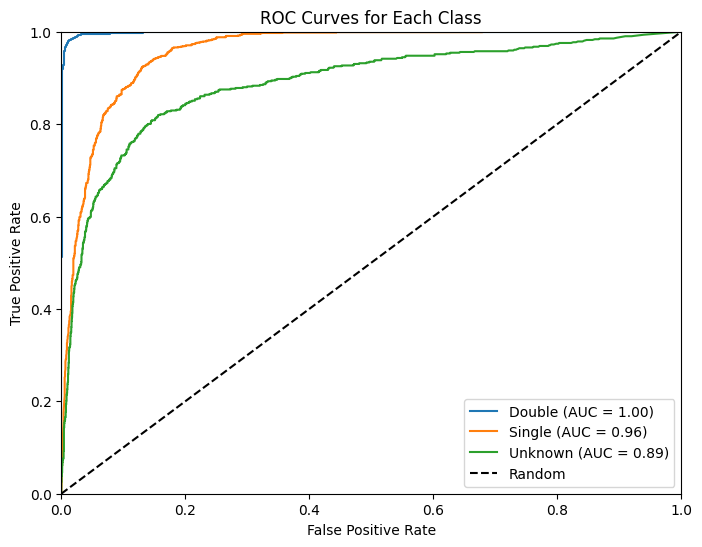

In [ ]:
# ---- ROC Curves ----
# For ROC curves, we need continuous scores for each class.
# Our downstream model outputs logits for known classes. We compute softmax probabilities,
# and define the unknown score as 1 - max(probability among known classes).
all_scores = []  # Will store (B, 3) arrays for each batch: [score_double, score_single, score_unknown]
all_labels_list = []  # True labels for each batch
model.eval()
with torch.no_grad():
    for images, labels in eval_loader:
        images = images.to(device)
        outputs = model(images)  # logits for known classes (shape: [B, 2])
        probs = F.softmax(outputs, dim=1)  # probabilities for known classes
        max_probs, _ = torch.max(probs, dim=1, keepdim=True)  # shape: (B, 1)
        p_unknown = 1 - max_probs  # Higher when the model is less confident on known classes.
        # Concatenate known class probabilities with the unknown score:
        scores = torch.cat([probs, p_unknown], dim=1)  # shape: (B, 3)
        all_scores.append(scores.cpu().numpy())
        all_labels_list.append(labels.cpu().numpy())
all_scores = np.concatenate(all_scores, axis=0)  # shape: (N, 3)
all_labels_arr = np.concatenate(all_labels_list, axis=0)  # shape: (N,)

# For multi-class ROC, we need to binarize the true labels.
y_true_bin = label_binarize(all_labels_arr, classes=[0, 1, 2])  # shape: (N, 3)

# Compute ROC curve and AUC for each class.
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves.
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(target_names):
    plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

# Model Setup: Backbone + Projection Head + Classifier

In [ ]:
# --- Load Fine-Tuned ResNet50 Backbone ---
# Load the fine-tuned ResNet50 (trained on "Double" and "Single")
backbone = models.resnet50(pretrained=False)
num_features = backbone.fc.in_features
# Replace final FC with Identity to get a 2048-dim feature vector
backbone.fc = nn.Identity()
backbone.load_state_dict(torch.load("resnet50_finetuned.pth"))
backbone.eval()  # Set to eval mode
# Optionally, freeze the backbone
for param in backbone.parameters():
    param.requires_grad = False

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FileNotFoundError: [Errno 2] No such file or directory: 'resnet50_finetuned.pth'